# **StereoNet** 🕶️ 

StereoNet is a disparity (depth) estimation model using a stereo pair of images (left/right) published by Google.  The original paper can be found [here](https://arxiv.org/abs/1807.08865).  This implementation was done by [Andrew Stewart](https://github.com/andrewlstewart) and is fully open source [here](https://github.com/andrewlstewart/StereoNet_PyTorch).  This implementation is totally unaffiliated with Google and the original authors. 

The StereoNet model uses a CNN feature extractor in a twin-network configuration, then computes a cost volume on these reduced spacial dimension embedded features, and finally uses a hierarchical refinement strategy which use both the RGB (or grayscale) images <i>and</i> the cost volume to compute an output disparity map.  This strategy is capable of generating highly detailed disparity maps including fine grained details.

The model checkpoint used in this notebook was trained on the [KeystoneDepth dataset](https://keystonedepth.cs.washington.edu/) (also from Google) and happens to be grayscale.

Example image and predicted disparity
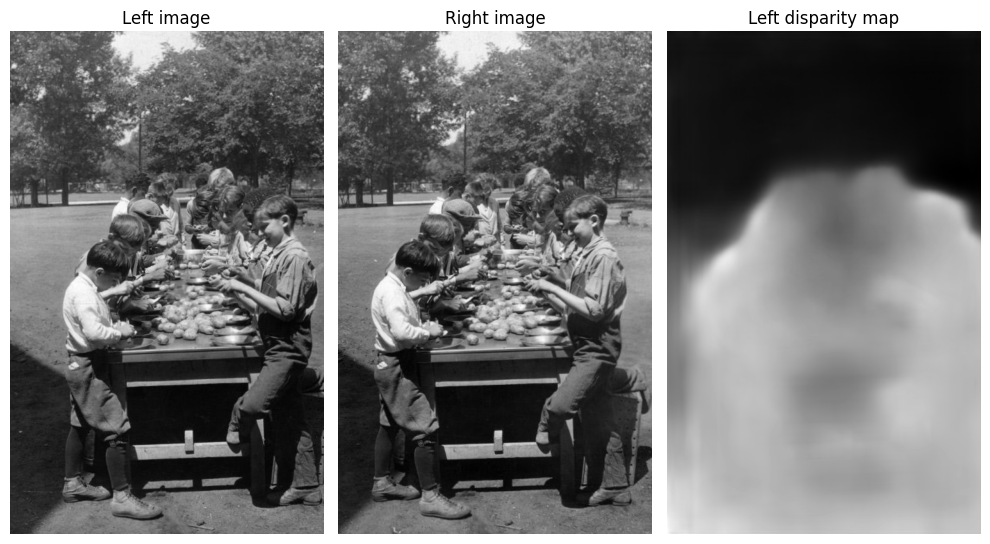

Let's get started!

###Setup

Ensure GPU is enabled (Edit -> Notebook settings -> GPU)

In [1]:
!nvidia-smi

Mon May  1 19:17:41 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070       WDDM | 00000000:01:00.0  On |                  N/A |
|  0%   48C    P0               39W / 180W|   2918MiB /  8192MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Install the StereoNet package.

In [ ]:
!pip install "git+https://github.com/andrewlstewart/StereoNet_PyTorch"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andrewlstewart/StereoNet_PyTorch to /tmp/pip-req-build-1k7ypvve
  Running command git clone --filter=blob:none --quiet https://github.com/andrewlstewart/StereoNet_PyTorch /tmp/pip-req-build-1k7ypvve
  Resolved https://github.com/andrewlstewart/StereoNet_PyTorch to commit 03859cda2861ff57a4cc2706968be64fd5651435
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 20.1 MB/s eta 0:00:00
  Preparing metadata 

##Python implementation

Colab/Jypyter notebook specific imports

In [28]:
import ipywidgets as widgets
from IPython.display import display

Example code related imports

In [3]:
import tempfile
import requests
import os

import matplotlib.pyplot as plt

StereoNet replated imports

In [4]:
import PIL.Image
import numpy as np
import torch
import torchvision.transforms

from stereonet.model import StereoNet
import stereonet.utils_io

Ensure notebook is using GPU

In [5]:
assert torch.cuda.is_available()
device = 'cuda:0'

Download the KeystoneDepth model checkpoint and load the StereoNet model

In [17]:
# Download the KeystoneDepth checkpoint (the checkpoint can obviously be downloaded and loaded directly from a local path)
checkpoint_url = "https://www.dropbox.com/s/ffgeqyzk4kec9cf/epoch%3D21-step%3D696366.ckpt?dl=1"
request = requests.get(checkpoint_url)
assert request.status_code == 200

# Load in the model from the trained checkpoint
with tempfile.TemporaryDirectory() as temp_dir:
    file_name = os.path.join(temp_dir, "model.ckpt")
    with open(file_name, 'wb') as f:
        f.write(request.content)
    model = StereoNet.load_from_checkpoint(file_name)

model = model.to(device)

Load in a couple of example images from the KeystoneDepth dataset (these examples are from the validation set that the model has <i>not</i> seen before.

In [19]:
# Download the left and right images (similarly, the images can be loaded directly from a local path)
left_image_url = "https://user-images.githubusercontent.com/7529012/235392110-cadeb58e-3f5a-4252-8002-44a6b9120b88.png"#"https://user-images.githubusercontent.com/7529012/235391713-8e0e1892-5bed-465f-962f-bdb7e91d63a2.png"
right_image_url = "https://user-images.githubusercontent.com/7529012/235392126-b5016b6a-897d-4b49-869b-603ed11dcf93.png"#"https://user-images.githubusercontent.com/7529012/235391750-be8f7816-7144-40bb-af39-28cc9439daff.png"

images = []
for url in (left_image_url, right_image_url):
    request = requests.get(url)
    assert request.status_code == 200
    with tempfile.TemporaryDirectory() as temp_dir:
        file_name = os.path.join(temp_dir, "image.png")
        with open(file_name, 'wb') as f:
            f.write(request.content)
        images.append(stereonet.utils_io.image_loader(file_name))

When creating a torch stack, all of the images have to have the same height and width.  This will perform a center crop.  This step can introduce errors if the images aren't well calibrated.

In [20]:
min_height = min(images[0].shape[0], images[1].shape[0])
min_width = min(images[0].shape[1], images[1].shape[1])

Put the images onto the GPU and in [Channel, Height, Width] order

In [21]:
tensored = [torch.permute(torch.from_numpy(array).to(torch.float32).to(device), (2, 0, 1)) for array in images]

Crop + stack the image pair

In [22]:
cropper = torchvision.transforms.CenterCrop((min_height, min_width))
stack = torch.concatenate(list(map(cropper, tensored)), dim=0)  # C, H, W

Zero mean/unit standard deviation normalize the images.  The specific values here were computed on the train set.

In [23]:
normalizer = torchvision.transforms.Normalize((111.5684, 113.6528), (61.9625, 62.0313))
normalized = normalizer(stack)

Model takes in a batch, therefore add a dummy axis.

In [24]:
batch = torch.unsqueeze(normalized, dim=0)  # B, C, H, W

Perform model inference in eval mode

In [25]:
model.eval()
with torch.no_grad():
  batched_prediction = model(batch)

Do some partial crops on the disparity predictions (most egregious errors are caused from disparities being not well defined on the left/right borders

In [78]:
crops = (1.0, 0.95, 0.9, 0.85)
predictions_torch = []
for crop_percentage in crops:
  cropper = torchvision.transforms.CenterCrop((round(min_height), round(min_width*crop_percentage)))
  predictions_torch.append(cropper(batched_prediction[0]))

# Convert from torch tensors on GPU to numpy arrays on CPU and switch back to channels last notation
predictions = [np.moveaxis(pred.detach().cpu().numpy(), 0, 2) for pred in predictions_torch]

Visalize the (left/right) image pair and the disparity maps for the various crops.  These disparity maps have been rescaled to [0, 255] so that they are easily viewed as images.

In [79]:
resized_predictions = []
for prediction in predictions:
    prediction = PIL.Image.fromarray(((prediction-prediction.min())/(prediction.max()-prediction.min())*255).astype(np.uint8)[..., 0])
    prediction = prediction.resize((images[0].shape[1], images[0].shape[0]))
    resized_predictions.append(np.array(prediction))

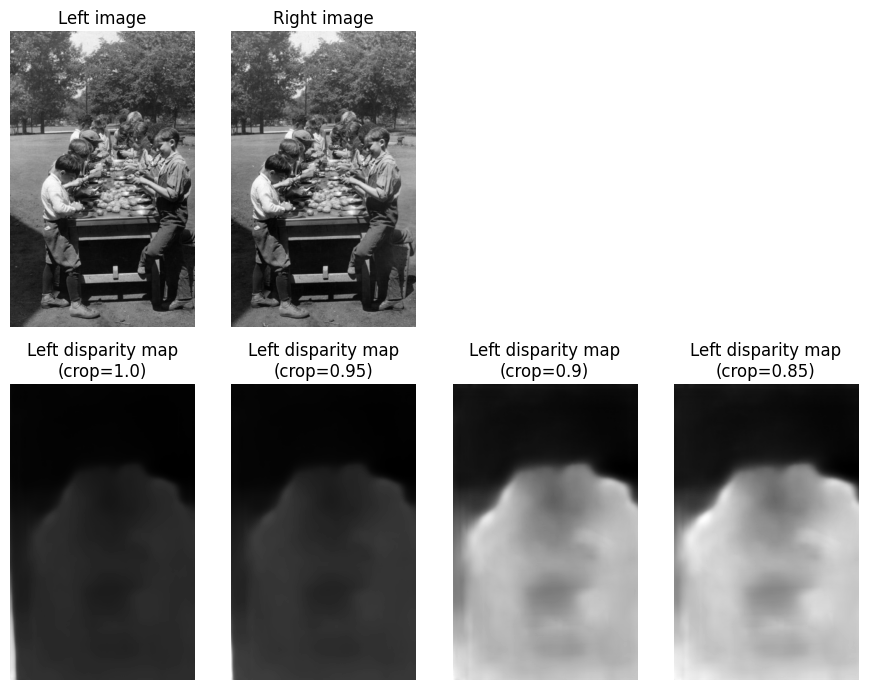

In [81]:
fig, ax = plt.subplots(nrows=2, ncols=len(predictions), figsize=(9, 7))
ax[0, 0].imshow(images[0], cmap='gray')
ax[0, 0].set_title("Left image")
ax[0, 1].imshow(images[1], cmap='gray')
ax[0, 1].set_title("Right image")
for idx, (prediction, crop) in enumerate(zip(resized_predictions, crops)):
    ax[1, idx].imshow(prediction, cmap='gray')
    ax[1, idx].set_title(f"Left disparity map\n(crop={crop})")
[axi.set_axis_off() for axi in ax.ravel()]
plt.tight_layout()

The full model, including training and validation code, if freely available on GitHub here: https://github.com/andrewlstewart/StereoNet_PyTorch

Fin.